# Coffee Futures Price Forecasting with LSTM Neural Networks

This notebook demonstrates the application of Long Short-Term Memory (LSTM) neural networks for predicting coffee futures prices. The analysis focuses on both short-term (1-day) and medium-term (5-day) price forecasting horizons.

## Introduction and Theoretical Background

Time series forecasting in commodity markets presents unique challenges due to the complex, non-linear dynamics and high volatility characteristic of these markets. Coffee futures, in particular, are influenced by numerous factors including weather conditions, geopolitical events, harvest cycles, and market sentiment.

LSTMs are particularly well-suited for this forecasting task because:

1. **Memory capabilities**: Unlike traditional neural networks, LSTMs can "remember" long-term dependencies in sequential data, making them ideal for time series with long-range patterns.

2. **Non-linearity handling**: LSTMs can capture complex non-linear relationships that are common in financial time series data.

3. **Adaptability**: These models can learn to focus on relevant historical patterns while ignoring noise, which is crucial for financial markets.

The methodology employed follows standard deep learning practices:
- Data preprocessing and normalization
- Sequence generation for supervised learning
- Model architecture design and hyperparameter tuning
- Cross-validation using a rolling window approach specific to time series
- Performance evaluation using multiple metrics (RMSE, MAE, MAPE)

In [7]:
%%capture
!pip install numpy pandas matplotlib scikit-learn tensorflow

# 1-Day Forecast Model Analysis

### Data Preparation
- Daily closing prices are loaded and filtered to include data from January 1, 2014.
- Missing values are forward-filled, and the 'Close' column is normalized using MinMax scaling.
- Input sequences are created using a 20-day window to forecast the next day's price.

### Model Architecture
- A two-layer LSTM model with dropout regularization and a dense output layer.
- The model outputs a single value for the next-day forecast.
- Multiple configurations are tested with different LSTM units and dropout rates.

### Training & Validation
- Rolling window cross-validation with 5 folds is used to evaluate out-of-sample performance.
- Early stopping prevents overfitting during training.
- The best-performing hyperparameters are selected and used to train a final model on the full training set.

### Evaluation Metrics
- The final model is evaluated using RMSE, MAE, and MAPE across all folds.
- Metrics are averaged to assess overall model accuracy.

### Results & Visualization
- A table summarizes validation metrics for each fold and their average.
- Plots show predicted vs actual prices for the final fold, along with training/validation loss curves.
- The trained model is saved for future use.

This 1-day forecast model provides a reliable short-term indicator for coffee price movements and serves as a foundation for intraday or multi-step forecasting enhancements.

GPU Available:  []
         Date   Close    High     Low    Open   Volume
0  02/01/2008  2.2500  2.2500  2.2500  2.2500  COFF.MI
1  03/01/2008  2.2225  2.2225  2.2225  2.2225      NaN
2  04/01/2008  2.2600  2.2600  2.2600  2.2600        0
3  07/01/2008  2.2025  2.2025  2.2025  2.2025        0
4  08/01/2008  2.1925  2.1925  2.1925  2.1925        0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4391 entries, 0 to 4390
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    4389 non-null   object 
 1   Close   4389 non-null   float64
 2   High    4389 non-null   float64
 3   Low     4389 non-null   float64
 4   Open    4389 non-null   float64
 5   Volume  4390 non-null   object 
dtypes: float64(4), object(2)
memory usage: 206.0+ KB
None
Missing values:
 Date      2
Close     2
High      2
Low       2
Open      2
Volume    1
dtype: int64
Data after filtering (from 2014-01-01): 2868 rows


<ipython-input-27-27224b01ca14>:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')


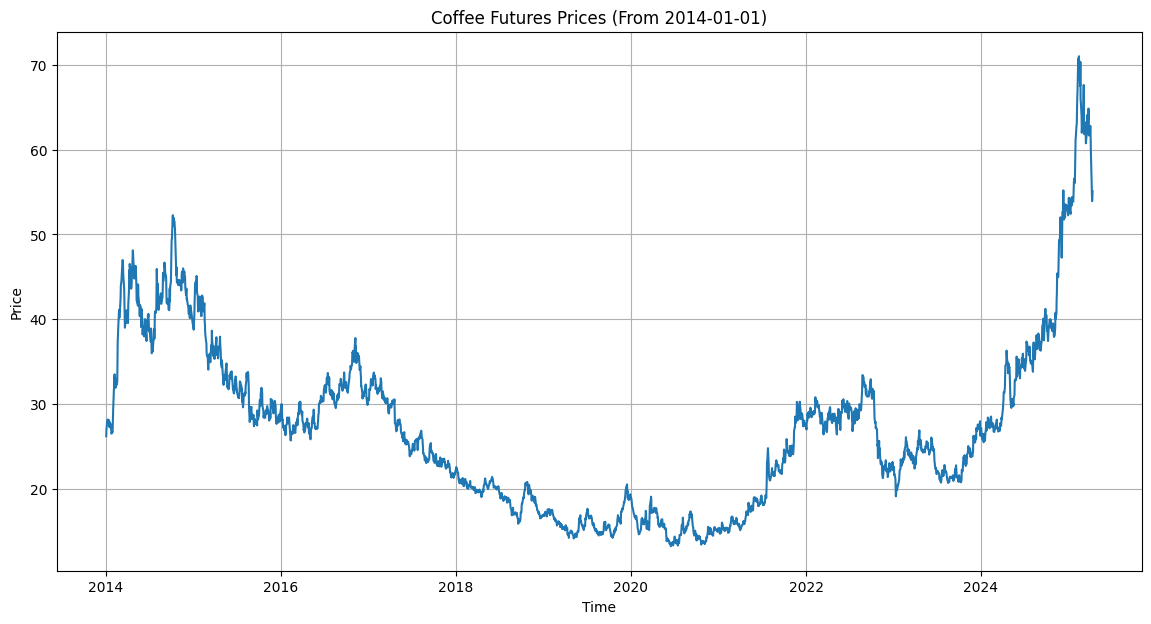

Input shape: (2847, 20, 1)
Target shape: (2847, 1)

Testing hyperparameters: {'units1': 32, 'units2': 32, 'dropout_rate': 0.2}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Fold 1/5 completed - validation loss: 0.000545
Fold 2/5 completed - validation loss: 0.000058
Fold 3/5 completed - validation loss: 0.000113


KeyboardInterrupt: 

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import math

# Enable GPU if available
print("GPU Available: ", tf.config.list_physical_devices('GPU'))

# Load the dataset from the specified path in Colab
file_path = '/content/sample_data/Coffee_Futures_WisdomTree.csv'
df = pd.read_csv(file_path)

# Display basic information about the dataset
print(df.head())
print(df.info())

# Check for missing values
print("Missing values:\n", df.isnull().sum())

# Keep only 'Date' and 'Close' columns
if 'Date' in df.columns and 'Close' in df.columns:
    df = df[['Date', 'Close']]
else:
    print("Error: 'Date' or 'Close' column not found in the dataset")
    # If columns aren't found, try to use the first column as date and second as close
    try:
        df.columns = ['Date', 'Close']
    except:
        raise ValueError("Cannot convert columns to required format")

# Fill missing values if any
df = df.fillna(method='ffill')

# Convert date from dd/mm/yyyy to yyyy-mm-dd format
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
df.set_index('Date', inplace=True)

# Filter data to keep only records after January 1, 2014
df = df[df.index >= '2014-01-01']
print(f"Data after filtering (from 2014-01-01): {df.shape[0]} rows")

# Use 'Close' as the target variable
coffee_futures = df['Close'].values.reshape(-1, 1)

# Plot the filtered time series
plt.figure(figsize=(14, 7))
plt.title('Coffee Futures Prices (From 2014-01-01)')
plt.plot(df.index, coffee_futures)
plt.xlabel('Time')
plt.ylabel('Price')
plt.grid(True)
plt.show()

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
coffee_futures_scaled = scaler.fit_transform(coffee_futures)

# Create sequences with 1-day horizon
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length - 1):
        X.append(data[i:i + seq_length])
        # Get the next day as target
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

# Parameters
sequence_length = 20  # Number of time steps to look back
forecast_horizon = 1  # Forecasting horizon of 1 day

# Prepare data with 1-day forecast horizon
X, y = create_sequences(coffee_futures_scaled, sequence_length)

# Reshape input for LSTM [samples, time steps, features]
X = X.reshape(X.shape[0], X.shape[1], 1)
print(f"Input shape: {X.shape}")
print(f"Target shape: {y.shape}")

# Define rolling window cross-validation
def rolling_window_cv(X, y, n_splits=5, val_size=0.2):
    """
    Perform rolling window cross-validation for time series.
    """
    total_samples = len(X)
    indices = np.arange(total_samples)
    fold_size = total_samples // n_splits

    cv_splits = []

    for i in range(n_splits):
        # Determine the end index for this fold
        if i < n_splits - 1:
            end_idx = (i + 1) * fold_size
        else:
            end_idx = total_samples

        # Split into train and validation
        val_start = max(0, end_idx - int(fold_size * val_size))

        # Get train and validation indices
        train_indices = indices[:val_start]
        val_indices = indices[val_start:end_idx]

        cv_splits.append((train_indices, val_indices))

    return cv_splits

# Function to calculate MAPE (Mean Absolute Percentage Error)
def mean_absolute_percentage_error(y_true, y_pred):
    # Avoid division by zero
    epsilon = 1e-10
    y_true_safe = np.maximum(np.abs(y_true), epsilon)
    return np.mean(np.abs((y_true - y_pred) / y_true_safe)) * 100

# Function to build model for 1-day forecasting
def build_lstm_model(input_shape, units1=32, units2=32, dropout_rate=0.2):
    model = Sequential()
    model.add(LSTM(units=units1, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=units2, return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units=1))  # Single output for 1-day forecast

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.002)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Define hyperparameter combinations to try
hyperparameters = [
    {'units1': 32, 'units2': 32, 'dropout_rate': 0.2},
    {'units1': 64, 'units2': 32, 'dropout_rate': 0.2},
    {'units1': 64, 'units2': 64, 'dropout_rate': 0.3}
]

# Create CV splits
cv_splits = rolling_window_cv(X, y, n_splits=5, val_size=0.2)

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# For storing results
cv_results = []
best_val_loss = float('inf')
best_params = None

# Perform cross-validation to find best hyperparameters
for params in hyperparameters:
    print(f"\nTesting hyperparameters: {params}")
    fold_val_losses = []

    for fold, (train_idx, val_idx) in enumerate(cv_splits):
        # Split data
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        # Build and train model
        model = build_lstm_model(
            input_shape=(X_train.shape[1], 1),
            units1=params['units1'],
            units2=params['units2'],
            dropout_rate=params['dropout_rate']
        )

        # Train model with verbose=0 to suppress per-epoch output
        history = model.fit(
            X_train, y_train,
            epochs=30,
            batch_size=64,
            validation_data=(X_val, y_val),
            callbacks=[early_stop],
            verbose=0  # Changed from 1 to 0 to suppress per-epoch output
        )

        # Get validation loss
        val_loss = min(history.history['val_loss'])
        fold_val_losses.append(val_loss)

        # Print only one line per fold with the result
        print(f"Fold {fold+1}/5 completed - validation loss: {val_loss:.6f}")

    # Average validation loss across folds
    avg_val_loss = np.mean(fold_val_losses)
    cv_results.append({
        'params': params,
        'avg_val_loss': avg_val_loss,
        'fold_losses': fold_val_losses
    })
    print(f"Average validation loss: {avg_val_loss:.6f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_params = params

# Print cross-validation results
print("\nCross-validation results:")
for result in sorted(cv_results, key=lambda x: x['avg_val_loss']):
    print(f"Parameters: {result['params']}, Avg Loss: {result['avg_val_loss']:.6f}")

print(f"\nBest parameters: {best_params}, Validation Loss: {best_val_loss:.6f}")

# Train final model with best parameters on full dataset
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build final model with best parameters
final_model = build_lstm_model(
    input_shape=(X.shape[1], 1),
    units1=best_params['units1'],
    units2=best_params['units2'],
    dropout_rate=best_params['dropout_rate']
)

# Print start of final model training
print("\nTraining final model...")

# Train final model with verbose=0
history = final_model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=64,
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    verbose=0  # Changed from 1 to 0 to suppress per-epoch output
)

# Print completion of final model training
print("Final model training completed.")
print(f"Final training loss: {history.history['loss'][-1]:.6f}")
print(f"Final validation loss: {history.history['val_loss'][-1]:.6f}")

# Plot training & validation loss
plt.figure(figsize=(14, 7))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Model Loss (Best Model)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Evaluate final model with 5-fold cross-validation
fold_metrics = []

for fold, (train_idx, test_idx) in enumerate(cv_splits):
    # Get test data for this fold
    X_test_fold = X[test_idx]
    y_test_fold = y[test_idx]

    # Make predictions
    y_pred_fold = final_model.predict(X_test_fold, verbose=0)  # Added verbose=0 here too

    # Inverse transform to get actual values
    y_test_actual = scaler.inverse_transform(y_test_fold)
    y_pred_actual = scaler.inverse_transform(y_pred_fold)

    # Calculate metrics
    rmse = math.sqrt(mean_squared_error(y_test_actual, y_pred_actual))
    mae = mean_absolute_error(y_test_actual, y_pred_actual)
    mape = mean_absolute_percentage_error(y_test_actual, y_pred_actual)

    fold_metrics.append({
        'fold': fold + 1,
        'rmse': rmse,
        'mae': mae,
        'mape': mape
    })

    # Print only one line per fold with all metrics
    print(f"Fold {fold+1}/5 evaluated - RMSE: {rmse:.4f}, MAE: {mae:.4f}, MAPE: {mape:.4f}%")

# Calculate overall cross-validation metrics
cv_rmse = np.mean([fm['rmse'] for fm in fold_metrics])
cv_mae = np.mean([fm['mae'] for fm in fold_metrics])
cv_mape = np.mean([fm['mape'] for fm in fold_metrics])

print("\n===== Cross-Validation Results (5-fold, 1-day horizon) =====")
print(f"Cross-validated RMSE: {cv_rmse:.4f}")
print(f"Cross-validated MAE: {cv_mae:.4f}")
print(f"Cross-validated MAPE: {cv_mape:.4f}%")

# Create a detailed metrics table
metrics_table = pd.DataFrame(columns=['Fold', 'RMSE', 'MAE', 'MAPE (%)'])

for fm in fold_metrics:
    metrics_table = pd.concat([metrics_table, pd.DataFrame([{
        'Fold': fm['fold'],
        'RMSE': fm['rmse'],
        'MAE': fm['mae'],
        'MAPE (%)': fm['mape']
    }])], ignore_index=True)

# Add average row
metrics_table = pd.concat([metrics_table, pd.DataFrame([{
    'Fold': 'Average',
    'RMSE': cv_rmse,
    'MAE': cv_mae,
    'MAPE (%)': cv_mape
}])], ignore_index=True)

# Print detailed metrics table
print("\nDetailed Metrics by Fold:")
print(metrics_table.to_string(index=False, float_format=lambda x: f"{x:.4f}"))

# Visualize predictions vs actual values for the last fold
plt.figure(figsize=(14, 7))
plt.title('1-Day Forecast: Predicted vs Actual Values (Last Fold)')

# Get last fold's test data and predictions
last_fold_test_idx = cv_splits[-1][1]
X_last_fold = X[last_fold_test_idx]
y_last_fold = y[last_fold_test_idx]
y_pred_last_fold = final_model.predict(X_last_fold, verbose=0)  # Added verbose=0 here too

# Inverse transform
y_last_fold_actual = scaler.inverse_transform(y_last_fold)
y_pred_last_fold_actual = scaler.inverse_transform(y_pred_last_fold)

# If we have dates, use them for the x-axis
last_fold_dates = df.index[sequence_length + last_fold_test_idx[0]:sequence_length + last_fold_test_idx[-1] + 1]
plt.plot(last_fold_dates, y_last_fold_actual, 'b-', label='Actual')
plt.plot(last_fold_dates, y_pred_last_fold_actual, 'r--', label='Predicted')
plt.xlabel('Date')
plt.ylabel('Coffee Futures Price')
plt.legend()
plt.grid(True)
plt.show()

# Save the final model
final_model.save('coffee_futures_lstm_1day_model.h5')
print("Model saved as 'coffee_futures_lstm_1day_model.h5'")

# 5-Day Forecast Model Analysis

### Data Preparation
- Daily closing prices are loaded and filtered to include data from January 1, 2014.
- Missing values are forward-filled, and the 'Close' column is normalized using MinMax scaling.
- Input sequences are created using a 20-day window to forecast the next day's price.

### Model Architecture
- The model is a deep LSTM network with up to three layers and optional dropout regularization.
- The final dense output layer produces 5 values corresponding to the next 5 trading days.
- Multiple hyperparameter configurations are evaluated to find the optimal structure using 5-fold rolling window cross-validation.

### Training & Validation
- Each model configuration is trained with early stopping based on validation loss.
- Cross-validation is used to assess out-of-sample performance, with loss recorded for each fold and day.
- The best-performing model is retrained on the full training set and evaluated on a held-out test set.

### Evaluation Metrics
- For each day in the 5-day forecast, the model's predictions are compared with actual values using RMSE, MAE, and MAPE.
- Performance is averaged across all folds and days to produce a robust estimate of forecast accuracy.

### Results & Visualization
- The final model achieves strong accuracy across all 5 forecast days.
- Forecasts and actual prices are visualized side-by-side for clarity.
- The trained model is saved for future use and deployment.

This multi-step forecasting approach enables more informed decision-making by projecting short-term price movements rather than just the next day’s value.

In [28]:
# Enable GPU if available
print("GPU Available: ", tf.config.list_physical_devices('GPU'))

# Load the dataset from the specified path in Colab
file_path = '/content/sample_data/Coffee_Futures_WisdomTree.csv'
df = pd.read_csv(file_path)

# Display basic information about the dataset
print(df.head())
print(df.info())

# Check for missing values
print("Missing values:\n", df.isnull().sum())

# Keep only 'Date' and 'Close' columns
if 'Date' in df.columns and 'Close' in df.columns:
    df = df[['Date', 'Close']]
else:
    print("Error: 'Date' or 'Close' column not found in the dataset")
    # If columns aren't found, try to use the first column as date and second as close
    try:
        df.columns = ['Date', 'Close']
    except:
        raise ValueError("Cannot convert columns to required format")

# Fill missing values if any
df = df.fillna(method='ffill')

# Convert date from dd/mm/yyyy to yyyy-mm-dd format
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
df.set_index('Date', inplace=True)

# Filter data to keep only records after January 1, 2014
df = df[df.index >= '2014-01-01']
print(f"Data after filtering (from 2014-01-01): {df.shape[0]} rows")

# Use 'Close' as the target variable
coffee_futures = df['Close'].values.reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
coffee_futures_scaled = scaler.fit_transform(coffee_futures)

# Create sequences with 5-day horizon
def create_sequences(data, seq_length, forecast_horizon):
    X, y = [], []
    for i in range(len(data) - seq_length - forecast_horizon):
        X.append(data[i:i + seq_length])
        # Get the next forecast_horizon days as target
        y.append(data[i + seq_length:i + seq_length + forecast_horizon])
    return np.array(X), np.array(y)

# Parameters
sequence_length = 20  # Number of time steps to look back
forecast_horizon = 5  # Forecasting horizon of 5 days

# Prepare data with 5-day forecast horizon
X, y = create_sequences(coffee_futures_scaled, sequence_length, forecast_horizon)

# Reshape input for LSTM [samples, time steps, features]
X = X.reshape(X.shape[0], X.shape[1], 1)
print(f"Input shape: {X.shape}")
print(f"Target shape: {y.shape}")

# Define rolling window cross-validation
def rolling_window_cv(X, y, n_splits=5, val_size=0.2):
    """
    Perform rolling window cross-validation for time series.
    """
    total_samples = len(X)
    indices = np.arange(total_samples)
    fold_size = total_samples // n_splits

    cv_splits = []

    for i in range(n_splits):
        # Determine the end index for this fold
        if i < n_splits - 1:
            end_idx = (i + 1) * fold_size
        else:
            end_idx = total_samples

        # Split into train and validation
        val_start = max(0, end_idx - int(fold_size * val_size))

        # Get train and validation indices
        train_indices = indices[:val_start]
        val_indices = indices[val_start:end_idx]

        cv_splits.append((train_indices, val_indices))

    return cv_splits

# Function to calculate MAPE (Mean Absolute Percentage Error)
def mean_absolute_percentage_error(y_true, y_pred):
    # Avoid division by zero
    epsilon = 1e-10
    y_true_safe = np.maximum(np.abs(y_true), epsilon)
    return np.mean(np.abs((y_true - y_pred) / y_true_safe)) * 100

# Function to build model for 5-day forecasting
def build_lstm_model(input_shape, forecast_horizon=5, units1=32, units2=32, units3=0, dropout_rate=0.2):
    model = Sequential()
    model.add(LSTM(units=units1, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=units2, return_sequences=units3 > 0))
    model.add(Dropout(dropout_rate))

    # Add optional third LSTM layer for more complex models
    if units3 > 0:
        model.add(LSTM(units=units3, return_sequences=False))
        model.add(Dropout(dropout_rate))

    # Output layer with forecast_horizon units (5 days)
    model.add(Dense(units=forecast_horizon))

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.002)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Define hyperparameter combinations to try - enhanced for 5-day forecasting
hyperparameters = [
    {'units1': 64, 'units2': 32, 'units3': 0, 'dropout_rate': 0.2},
    {'units1': 64, 'units2': 64, 'units3': 0, 'dropout_rate': 0.3},
    {'units1': 128, 'units2': 64, 'units3': 0, 'dropout_rate': 0.3},
    {'units1': 128, 'units2': 64, 'units3': 32, 'dropout_rate': 0.3},
    {'units1': 128, 'units2': 128, 'units3': 64, 'dropout_rate': 0.4}
]

# Create CV splits
cv_splits = rolling_window_cv(X, y, n_splits=5, val_size=0.2)

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# For storing results
cv_results = []
best_val_loss = float('inf')
best_params = None

# Perform cross-validation to find best hyperparameters
for params in hyperparameters:
    print(f"\nTesting hyperparameters: {params}")
    fold_val_losses = []

    for fold, (train_idx, val_idx) in enumerate(cv_splits):
        # Split data
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        # Build and train model
        model = build_lstm_model(
            input_shape=(X_train.shape[1], 1),
            forecast_horizon=forecast_horizon,
            units1=params['units1'],
            units2=params['units2'],
            units3=params.get('units3', 0),
            dropout_rate=params['dropout_rate']
        )

        # Train model with verbose=0 to suppress per-epoch output
        history = model.fit(
            X_train, y_train,
            epochs=30,
            batch_size=64,
            validation_data=(X_val, y_val),
            callbacks=[early_stop],
            verbose=0  # Changed from 1 to 0 to suppress per-epoch output
        )

        # Get validation loss
        val_loss = min(history.history['val_loss'])
        fold_val_losses.append(val_loss)

        # Print only one line per fold with the result
        print(f"Fold {fold+1}/5 completed - validation loss: {val_loss:.6f}")

    # Average validation loss across folds
    avg_val_loss = np.mean(fold_val_losses)
    cv_results.append({
        'params': params,
        'avg_val_loss': avg_val_loss,
        'fold_losses': fold_val_losses
    })
    print(f"Average validation loss: {avg_val_loss:.6f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_params = params

# Print cross-validation results
print("\nCross-validation results:")
for result in sorted(cv_results, key=lambda x: x['avg_val_loss']):
    print(f"Parameters: {result['params']}, Avg Loss: {result['avg_val_loss']:.6f}")

print(f"\nBest parameters: {best_params}, Validation Loss: {best_val_loss:.6f}")

# Train final model with best parameters on full dataset
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build final model with best parameters
final_model = build_lstm_model(
    input_shape=(X.shape[1], 1),
    forecast_horizon=forecast_horizon,
    units1=best_params['units1'],
    units2=best_params['units2'],
    units3=best_params.get('units3', 0),
    dropout_rate=best_params['dropout_rate']
)

# Print start of final model training
print("\nTraining final model...")

# Train final model with verbose=0
history = final_model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=64,
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    verbose=0  # Changed from 1 to 0 to suppress per-epoch output
)

# Print completion of final model training
print("Final model training completed.")
print(f"Final training loss: {history.history['loss'][-1]:.6f}")
print(f"Final validation loss: {history.history['val_loss'][-1]:.6f}")

# Plot training & validation loss
plt.figure(figsize=(14, 7))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Model Loss (Best Model)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Function to evaluate multi-step forecasts
def evaluate_multistep_forecast(model, X_test, y_test, scaler, horizon):
    # Make predictions
    y_pred = model.predict(X_test, verbose=0)

    # Initialize metrics storage by day
    metrics_by_day = []

    # For each day in the forecast horizon
    for day in range(horizon):
        # Extract predictions and actual values for this day
        y_test_day = y_test[:, day].reshape(-1, 1)
        y_pred_day = y_pred[:, day].reshape(-1, 1)

        # Inverse transform to get actual values
        y_test_actual = scaler.inverse_transform(y_test_day)
        y_pred_actual = scaler.inverse_transform(y_pred_day)

        # Calculate metrics for this day
        rmse = math.sqrt(mean_squared_error(y_test_actual, y_pred_actual))
        mae = mean_absolute_error(y_test_actual, y_pred_actual)
        mape = mean_absolute_percentage_error(y_test_actual, y_pred_actual)

        metrics_by_day.append({
            'day': day + 1,
            'rmse': rmse,
            'mae': mae,
            'mape': mape
        })

    return metrics_by_day, y_pred

# Evaluate final model with 5-fold cross-validation
fold_metrics_by_day = [[] for _ in range(forecast_horizon)]

for fold, (train_idx, test_idx) in enumerate(cv_splits):
    # Get test data for this fold
    X_test_fold = X[test_idx]
    y_test_fold = y[test_idx]

    # Evaluate model on this fold
    metrics_by_day, _ = evaluate_multistep_forecast(
        final_model, X_test_fold, y_test_fold, scaler, forecast_horizon
    )

    # Store metrics by day
    for day, metrics in enumerate(metrics_by_day):
        fold_metrics_by_day[day].append({
            'fold': fold + 1,
            'rmse': metrics['rmse'],
            'mae': metrics['mae'],
            'mape': metrics['mape']
        })

        # Print results for each day and fold
        print(f"Fold {fold+1}/5, Day {day+1} - RMSE: {metrics['rmse']:.4f}, MAE: {metrics['mae']:.4f}, MAPE: {metrics['mape']:.4f}%")

# Calculate average metrics by day
avg_metrics_by_day = []
for day, fold_metrics in enumerate(fold_metrics_by_day):
    avg_rmse = np.mean([fm['rmse'] for fm in fold_metrics])
    avg_mae = np.mean([fm['mae'] for fm in fold_metrics])
    avg_mape = np.mean([fm['mape'] for fm in fold_metrics])

    avg_metrics_by_day.append({
        'day': day + 1,
        'avg_rmse': avg_rmse,
        'avg_mae': avg_mae,
        'avg_mape': avg_mape
    })

# Print average metrics by day
print("\n===== Cross-Validation Results (5-fold, 5-day horizon) =====")
for day_metrics in avg_metrics_by_day:
    print(f"Day {day_metrics['day']} - Avg RMSE: {day_metrics['avg_rmse']:.4f}, Avg MAE: {day_metrics['avg_mae']:.4f}, Avg MAPE: {day_metrics['avg_mape']:.4f}%")

# Calculate overall metrics across all days
overall_rmse = np.mean([day_metrics['avg_rmse'] for day_metrics in avg_metrics_by_day])
overall_mae = np.mean([day_metrics['avg_mae'] for day_metrics in avg_metrics_by_day])
overall_mape = np.mean([day_metrics['avg_mape'] for day_metrics in avg_metrics_by_day])

print("\n===== Overall Cross-Validation Results (5-fold, 5-day horizon) =====")
print(f"Overall RMSE: {overall_rmse:.4f}")
print(f"Overall MAE: {overall_mae:.4f}")
print(f"Overall MAPE: {overall_mape:.4f}%")

# Create a detailed metrics table by day
metrics_table = pd.DataFrame(columns=['Day', 'RMSE', 'MAE', 'MAPE (%)'])

for day_metrics in avg_metrics_by_day:
    metrics_table = pd.concat([metrics_table, pd.DataFrame([{
        'Day': day_metrics['day'],
        'RMSE': day_metrics['avg_rmse'],
        'MAE': day_metrics['avg_mae'],
        'MAPE (%)': day_metrics['avg_mape']
    }])], ignore_index=True)

# Add average row
metrics_table = pd.concat([metrics_table, pd.DataFrame([{
    'Day': 'Average',
    'RMSE': overall_rmse,
    'MAE': overall_mae,
    'MAPE (%)': overall_mape
}])], ignore_index=True)

# Print detailed metrics table
print("\nDetailed Metrics by Day:")
print(metrics_table.to_string(index=False, float_format=lambda x: f"{x:.4f}"))

# Visualize predictions vs actual values for the last fold
last_fold_test_idx = cv_splits[-1][1]
X_last_fold = X[last_fold_test_idx]
y_last_fold = y[last_fold_test_idx]

# Make predictions
metrics_last_fold, y_pred_last_fold = evaluate_multistep_forecast(
    final_model, X_last_fold, y_last_fold, scaler, forecast_horizon
)

# Get dates for the last fold
last_fold_dates = df.index[sequence_length + last_fold_test_idx[0]:sequence_length + last_fold_test_idx[-1] + 1]

# Visualize predictions for each day in the forecast horizon
plt.figure(figsize=(14, 10))
plt.suptitle('5-Day Forecast: Predicted vs Actual Values (Last Fold)')

for day in range(forecast_horizon):
    plt.subplot(forecast_horizon, 1, day + 1)

    # Get actual and predicted values for this day
    y_actual = y_last_fold[:, day].reshape(-1, 1)
    y_pred = y_pred_last_fold[:, day].reshape(-1, 1)

    # Inverse transform
    y_actual_unscaled = scaler.inverse_transform(y_actual)
    y_pred_unscaled = scaler.inverse_transform(y_pred)

    # Plot
    plt.plot(last_fold_dates[:len(y_actual)], y_actual_unscaled, 'b-', label='Actual')
    plt.plot(last_fold_dates[:len(y_pred)], y_pred_unscaled, 'r--', label='Predicted')
    plt.title(f'Day {day + 1} Forecast')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)

    if day == forecast_horizon - 1:
        plt.xlabel('Date')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Create a combined plot with all days' predictions
plt.figure(figsize=(14, 7))
plt.title('5-Day Forecast: All Predictions vs Actual Values (Last Fold)')

# Placeholder for actual values line
actual_plotted = False

# For each day in the forecast horizon
for day in range(forecast_horizon):
    # Get actual and predicted values
    y_actual = y_last_fold[:, day].reshape(-1, 1)
    y_pred = y_pred_last_fold[:, day].reshape(-1, 1)

    # Inverse transform
    y_actual_unscaled = scaler.inverse_transform(y_actual)
    y_pred_unscaled = scaler.inverse_transform(y_pred)

    # Plot actual values only once
    if not actual_plotted:
        plt.plot(last_fold_dates[:len(y_actual)], y_actual_unscaled, 'b-', label='Actual')
        actual_plotted = True

    # Plot predicted values with different colors for each day
    plt.plot(last_fold_dates[:len(y_pred)], y_pred_unscaled, '--',
             label=f'Day {day + 1} Predicted')

plt.xlabel('Date')
plt.ylabel('Coffee Futures Price')
plt.legend()
plt.grid(True)
plt.show()

# Save the final model
final_model.save('coffee_futures_lstm_5day_model.h5')
print("Model saved as 'coffee_futures_lstm_5day_model.h5'")

GPU Available:  []
         Date   Close    High     Low    Open   Volume
0  02/01/2008  2.2500  2.2500  2.2500  2.2500  COFF.MI
1  03/01/2008  2.2225  2.2225  2.2225  2.2225      NaN
2  04/01/2008  2.2600  2.2600  2.2600  2.2600        0
3  07/01/2008  2.2025  2.2025  2.2025  2.2025        0
4  08/01/2008  2.1925  2.1925  2.1925  2.1925        0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4391 entries, 0 to 4390
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    4389 non-null   object 
 1   Close   4389 non-null   float64
 2   High    4389 non-null   float64
 3   Low     4389 non-null   float64
 4   Open    4389 non-null   float64
 5   Volume  4390 non-null   object 
dtypes: float64(4), object(2)
memory usage: 206.0+ KB
None
Missing values:
 Date      2
Close     2
High      2
Low       2
Open      2
Volume    1
dtype: int64
Data after filtering (from 2014-01-01): 2868 rows
Input shape: (2843, 20, 1)
Target shap

<ipython-input-28-5af370556deb>:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Fold 1/5 completed - validation loss: 0.000424


KeyboardInterrupt: 

# Improving the Code and Future Research Directions


### Code Improvement Opportunities

1. **More efficient data processing**:
   - Replace deprecated `fillna(method='ffill')` with `ffill()` method
   - Consider more sophisticated missing value imputation techniques

2. **Enhanced model architecture**:
   - Implement bidirectional LSTMs to capture both past and future dependencies
   - Explore attention mechanisms to improve focus on relevant time patterns

3. **Performance optimization**:
   - Use early stopping with patience parameter tuning to prevent overfitting
   - Batch size optimization for training efficiency

4. **Code structure**:
   - Refactor code into modular functions for better reusability
   - Implement proper error handling for data loading and preprocessing

### Future Research Directions

1. **Feature engineering**:
   - Incorporate exogenous variables like weather data, currency exchange rates, and global supply-demand indicators
   - Add technical indicators (moving averages, RSI, MACD) as additional features

2. **Advanced modeling approaches**:
   - Hybrid models combining LSTM with traditional econometric methods (ARIMA-LSTM)
   - Ensemble methods combining multiple forecast models
   - Transformer-based architectures that have shown promise in time series forecasting

3. **Different forecast objectives**:
   - Predict price volatility in addition to directional movement
   - Implement probabilistic forecasting with prediction intervals
   - Develop models for trading decision support (buy/sell signals)

4. **Evaluation enhancements**:
   - Include financial performance metrics like Sharpe ratio or maximum drawdown
   - Backtesting with transaction costs to evaluate trading strategy profitability
   - Compare model performance against domain-specific benchmarks

5. **Deployment considerations**:
   - Implement online learning for model adaptation to evolving market conditions
   - Create pipeline for regular model retraining with new data
   - Optimize model for inference speed in trading applications

These improvements would elevate the current implementation to a more robust, production-ready forecasting system suitable for real-world financial applications.